In [ ]:
def determine(lst):
    return (all(x == 0.0 for x in lst))

def check_zeros(data):
    new_data = []
    for i in data:
        if not determine(i[1]):
            if new_data == None:
                new_data = i
            else:
                new_data.append(i)
#     data = [i for i in data if not determine(i[1])]
#     for item in data[:]:
#         if sum(item[1]) == 0:
#             data.pop(data.index(item))
    # for i, value in enumerate(data.copy()):
    #     if sum(value[1]) == 0:
    #         data.pop(i)
    return new_data


def merge_amino_nuc(amino, nuc):
    final_df = nuc
    return final_df.join(amino.iloc[:, :2].set_index('pid'), on='pid', how='inner')


#get all the data from a specific order
def get_data_order(data, order_name):
    new_data = []

    if (order_name == 'Coleoptera'):
        index_one = 0
    elif (order_name == 'Diptera'):
        index_one = 1
    elif (order_name == 'Hymenoptera'):
        index_one = 2
    elif (order_name == 'Lepidoptera'):
        index_one = 3
    
    for i in range(len(data)):
        code_order = data[i][2][index_one]
        if(code_order == 1):
            data[i][2] = [1,0]
        else:
            data[i][2] = [0,1]
        new_data.append(data[i])
            
    return new_data

def read_pids_fasta(file_fasta):
    pids = []
    for record in SeqIO.parse(file_fasta, "fasta"):
        record_id = record.id
        pids.append(record_id.split("|")[0])        
    return pids

def save_object(obj, filename):
    with open(filename, 'wb') as output:  
        pickle.dump(obj, output, protocol=2)
        
def split_new(data,training_percent):
    training_percent = float(training_percent)
    for i in range(len(data)):
        if i < int(len(data)*training_percent):
            data[i].append(['train'])
        else:
            data[i].append(['test'])
    return data
    
def split(feature_file,training_percent):

    training_percent = float(training_percent)
    
    with open("../feature_data/" + feature_file, 'rb') as file:
        data = pickle.load(file)
        for i in range(len(data)):
            if i < int(len(data)*training_percent):
                data[i].append(['train'])
            else:
                data[i].append(['test'])
        return data
        #save_object(data, "train_and_test/tt-" + str(training_percent) + "-" + feature_file)

def build_DNN(train_x,train_y):
    tf.reset_default_graph()
    # Build neural network - input data shape, number of words in vocabulary (size of first array element). 
    net = tflearn.input_data(shape=[None, len(train_x[0])])
    # Two fully connected layers with 8 hidden units/neurons - optimal for this task
    net = tflearn.fully_connected(net, 4)
    net = tflearn.fully_connected(net, 4,activation='softmax')
    # number of intents, columns in the matrix train_y
    #net = tflearn.fully_connected(net, len(train_y[0]), activation='softmax')
    # regression to find best parameters, during training
    net = tflearn.regression(net)

    # Define Deep Neural Network model and setup tensorboard
    model = tflearn.DNN(net, tensorboard_dir='tflearn_sequence_logs')
    return modell

def build_DNN_Arch1(aa_length, nu_length,train_y):
    tf.reset_default_graph()
    # Build neural network - input data shape, number of words in vocabulary (size of first array element). 
    net_aa = tflearn.input_data(shape=[None, aa_length], name="InputData0")
    net_nu = tflearn.input_data(shape=[None, nu_length], name="InputData1")
    # Two fully connected layers with 8 hidden units/neurons
    net_aa = tflearn.fully_connected(net_aa, 4)
    net_nu = tflearn.fully_connected(net_nu, 4)
    # number of intents, columns in the matrix train_y
    net = tflearn.merge_outputs([net_aa, net_nu])
    net = tflearn.fully_connected(net, 4)
    net = tflearn.fully_connected(net, len(train_y[0]), activation='sigmoid')
    # regression to find best parameters, during training
    net = tflearn.regression(net, optimizer='adam')

    # Define Deep Neural Network model and setup tensorboard
    model = tflearn.DNN(net, tensorboard_dir='tflearn_arch1_logs', tensorboard_verbose=3)
    return model

def build_DNN_Arch2(aa_length, nu_length,train_y):
    tf.reset_default_graph()
    # Build neural network - input data shape, number of words in vocabulary (size of first array element). 
    net_aa = tflearn.input_data(shape=[None, aa_length], name="InputData0")
    net_nu = tflearn.input_data(shape=[None, nu_length], name="InputData1")
    # Two fully connected layers with 8 hidden units/neurons
#     net_aa = tflearn.fully_connected(net_aa, 4)
    net_nu = tflearn.fully_connected(net_nu, 4)
    # number of intents, columns in the matrix train_y
    net = tflearn.merge_outputs([net_aa, net_nu])
    net = tflearn.fully_connected(net, 4)
    net = tflearn.fully_connected(net, len(train_y[0]), activation='sigmoid')
    # regression to find best parameters, during training
    net = tflearn.regression(net, optimizer='adam')

    # Define Deep Neural Network model and setup tensorboard
    model = tflearn.DNN(net, tensorboard_dir='tflearn_arch2_logs', tensorboard_verbose=3)
    return model

def train_DNN(model, train_x,train_y,classes):
    # Start training (apply gradient descent algorithm)
    # n_epoch - number of epoch to run
    # Batch size defines number of samples that going to be propagated through the network.
    model.fit(train_x, train_y, n_epoch=5, batch_size=5, show_metric=True)
    model.save('model/'+classes[0]+'_'+classes[1]+'.tflearn')

def train_DNN_arch12(model, train_aa, train_nu, train_y,classe,arch,grp):
    # Start training (apply gradient descent algorithm)
    # n_epoch - number of epoch to run
    # Batch size defines number of samples that going to be propagated through the network.
    model.fit({"InputData0":train_aa,"InputData1":train_nu}, train_y, n_epoch=5, batch_size=5, show_metric=True)
    model_name = 'model/'+classe+'_block_'+grp+'_'+arch+'.tflearn'
    model.save(model_name)
    return model_name
    
def predict_old(frequency,model,classes):

    ERROR_THRESHOLD = 0.5
    
    # generate probabilities from the model
    results = model.predict(frequency)[0]

    # filter out predictions below a threshold, and provide intent index
    results = [[i,r] for i,r in enumerate(results) if r>ERROR_THRESHOLD]

    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
        return_list.append(classes[r[0]])
    
    return return_list

def predict(model, test_aa, test_nu,classes):
    results = model.predict({"InputData0":[test_aa],"InputData1":[test_nu]})[0]

    new_results = results
    if results[0] > results[1]:
        #new_results[0] = results[0]
        #new_results[1] = results[1]
        class_result = 0
    else:
        #new_results[0] = results[1]
        #new_results[1] = results[0]
        class_result = 1

    #return_list = []
    #return_list.append((classes[class_result], str(new_results[0])))
    return classes[class_result], float(results[0]), float(results[1])

def predict_with_threshold(model, test_aa, test_nu,classes):
    
    THRESHOLD = 0.5
        
    results = model.predict({"InputData0":[test_aa],"InputData1":[test_nu]})[0]
    
    if(results[0] >= THRESHOLD):
        class_index = 0 #The first class is the positive class
    else:
        class_index = 1 

    return classes[class_index], results[0]

def fix_format(string):
    return re.sub('[\[\]\']','',string)

def plot_roc(y_test,y_score):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    y_test = array(y_test)
    y_score = array(y_score)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    roc_auc = auc(fpr, tpr)

    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

def metrics_DNN(predict_y,test_y,classes,scores):
    
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    id_misclassified = []
    pred_misclassified = []
    y_misclassified = []
    
    #class[0] is the positive class, test_y == 1 is the positive class
    for i in range(len(predict_y)):
        if (predict_y[i] == classes[0] and test_y[i] == 1):
            true_positive += 1
            
        elif (predict_y[i] == classes[1] and test_y[i] == 0):
            true_negative += 1
            
        elif(predict_y[i] == classes[1] and test_y[i] == 1):
            false_negative += 1
            pred_misclassified.append(predict_y[i])
            y_misclassified.append(classes[0])
            
        elif(predict_y[i] == classes[0] and test_y[i] == 0):
            false_positive += 1
            pred_misclassified.append(predict_y[i])
            y_misclassified.append(classes[1])
    
    
    #df_misclassified = pd.DataFrame({'id': id_misclassified,'predicted': pred_misclassified,'real_class': y_misclassified})
            
    precision_classe0 = float(true_positive)/(true_positive + false_positive)
    sensitivity = float(true_positive)/(true_positive + false_negative) #recall for class0
    F1_score_class0 = 2*(float(precision_classe0*sensitivity)/(precision_classe0 + sensitivity))
    
    precision_classe1 = float(true_negative)/(true_negative + false_negative)
    specificity = float(true_negative)/(false_positive + true_negative)#recall for class1
    F1_score_class1 = 2*(float(precision_classe1*specificity)/(precision_classe1 + specificity))
    
    accuracy = float(true_positive + true_negative)/len(predict_y)
    
    print("Class " + classes[0] +":")
    print("Precision: " + str(precision_classe0))
    print("Sensitivity: " + str(sensitivity))
    print("F1 score: " + str(F1_score_class0))
    
    print("")
    
    print("Class " + classes[1] +":")
    print("Precision: " + str(precision_classe1))
    print("Specificity: " + str(specificity))
    print("F1 score: " + str(F1_score_class1))
    
    print("")
    
    print("Accuracy:")
    print(accuracy)
    
    plot_roc(test_y,scores)
    
    #return df_misclassified

In [2]:
def get_train_test_data(nu_list,aa_list):
    index_pid = 0
    index_x = 1
    index_y = 2
    index_label = 3
    train_aa_x = [] 
    train_nu_x = []
    data_y_train = [] 
    test_aa_x = []
    test_nu_x = []
    data_y_test = []
    pids_test = []
    
    for i in range(len(nu_list)):
        if ((nu_list[i][index_label][0]) == 'train'):
            train_nu_x.append(nu_list[i][index_x])
            data_y_train.append(nu_list[i][index_y])
        else:
            test_nu_x.append(nu_list[i][index_x])
            data_y_test.append(nu_list[i][index_y])
            pids_test.append(nu_list[i][index_pid])
            
    for i in range(len(aa_list)):
        if ((aa_list[i][index_label][0]) == 'train'):
            train_aa_x.append(aa_list[i][index_x])
        else:
            test_aa_x.append(aa_list[i][index_x])
            
    return train_aa_x, train_nu_x, data_y_train, test_aa_x, test_nu_x, data_y_test, pids_test

In [26]:
def Average(lst): 
    return sum(lst) / len(lst) 

In [27]:
def combination_1(scores_pos, scores_neg,classes):
    avr_pos = Average(scores_pos)
    avr_neg = Average(scores_neg)
    
    if (avr_pos >= avr_neg):
        return classes[0], avr_pos
    else:
        return classes[1], avr_pos #always return the positive probability

In [3]:
import numpy as np
import tflearn
import tensorflow as tf
import random
import pickle
from collections import Counter
from sklearn.model_selection import KFold, cross_val_score
import argparse
import pandas as pd
import re
from sklearn.metrics import roc_curve, auc
from numpy import array
import matplotlib.pyplot as plt

In [4]:
classes = ['Lepidoptera', 'not_Lepidoptera']

nuc_data_first = {}
nuc_data_second = {}
nuc_data_third = {}
nuc_data_fourth = {}
amino_data_first = {}
amino_data_second = {}
amino_data_third = {}
amino_data_fourth = {}


with open("ensemble_data_0401/1nucblock-235-mer-top-10coleopteradipterahymenopteralepidoptera-ratio.pkl", 'rb') as file:
    nuc_data_first = pickle.load(file)
    #print(nuc_data_first[0])
with open("ensemble_data_0401/2nucblock-235-mer-top-10coleopteradipterahymenopteralepidoptera-ratio.pkl", 'rb') as file:
    nuc_data_second = pickle.load(file)
    #print(nuc_data_second[0])
with open("ensemble_data_0401/3nucblock-235-mer-top-10coleopteradipterahymenopteralepidoptera-ratio.pkl", 'rb') as file:
    nuc_data_third = pickle.load(file)
    #print(nuc_data_third[0])
with open("ensemble_data_0401/4nucblock-235-mer-top-10coleopteradipterahymenopteralepidoptera-ratio.pkl", 'rb') as file:
    nuc_data_fourth = pickle.load(file)
    #print(nuc_data_fourth[0])
with open("ensemble_data_0401/1aminoblock-235-mer-top-10coleopteradipterahymenopteralepidoptera-ratio.pkl", 'rb') as file:
    amino_data_first = pickle.load(file)
    #print(amino_data_first[0])
with open("ensemble_data_0401/2aminoblock-235-mer-top-10coleopteradipterahymenopteralepidoptera-ratio.pkl", 'rb') as file:
    amino_data_second = pickle.load(file)
    #print(amino_data_second[0])
with open("ensemble_data_0401/3aminoblock-235-mer-top-10coleopteradipterahymenopteralepidoptera-ratio.pkl", 'rb') as file:
    amino_data_third = pickle.load(file)
    #print(amino_data_third[0])
with open("ensemble_data_0401/4aminoblock-235-mer-top-10coleopteradipterahymenopteralepidoptera-ratio.pkl", 'rb') as file:
    amino_data_fourth = pickle.load(file)
    #print(amino_data_fourth[0])

In [5]:
print(len(nuc_data_first))
print(len(nuc_data_second))
print(len(nuc_data_third))
print(len(nuc_data_fourth))
print(len(amino_data_first))
print(len(amino_data_second))
print(len(amino_data_third))
print(len(amino_data_fourth))

353340
353539
354195
347431
353023
339718
348800
253134


In [6]:
nuc_data_first_lepidoptera = check_zeros(nuc_data_first)
nuc_data_second_lepidoptera = check_zeros(nuc_data_second)
nuc_data_third_lepidoptera = check_zeros(nuc_data_third)
nuc_data_fourth_lepidoptera = check_zeros(nuc_data_fourth)
amino_data_first_lepidoptera = check_zeros(amino_data_first)
amino_data_second_lepidoptera = check_zeros(amino_data_second)
amino_data_third_lepidoptera = check_zeros(amino_data_third)
amino_data_fourth_lepidoptera = check_zeros(amino_data_fourth)

In [7]:
for i in amino_data_fourth_lepidoptera:
    if determine(i[1]):
        print(i)

In [8]:
"""
print(len(nuc_data_first_lepidoptera))
print(len(nuc_data_second_lepidoptera))
print(len(nuc_data_third_lepidoptera))
print(len(nuc_data_fourth_lepidoptera))
print(len(amino_data_first_lepidoptera))
print(len(amino_data_second_lepidoptera))
print(len(amino_data_third_lepidoptera))
print(len(amino_data_fourth_lepidoptera))
"""

'\nprint(len(nuc_data_first_lepidoptera))\nprint(len(nuc_data_second_lepidoptera))\nprint(len(nuc_data_third_lepidoptera))\nprint(len(nuc_data_fourth_lepidoptera))\nprint(len(amino_data_first_lepidoptera))\nprint(len(amino_data_second_lepidoptera))\nprint(len(amino_data_third_lepidoptera))\nprint(len(amino_data_fourth_lepidoptera))\n'

In [9]:
nuc_data_first_lepidoptera = get_data_order(nuc_data_first_lepidoptera, classes[0])
nuc_data_second_lepidoptera = get_data_order(nuc_data_second_lepidoptera, classes[0])
nuc_data_third_lepidoptera = get_data_order(nuc_data_third_lepidoptera, classes[0])
nuc_data_fourth_lepidoptera = get_data_order(nuc_data_fourth_lepidoptera, classes[0])
amino_data_first_lepidoptera = get_data_order(amino_data_first_lepidoptera, classes[0])
amino_data_second_lepidoptera = get_data_order(amino_data_second_lepidoptera, classes[0])
amino_data_third_lepidoptera = get_data_order(amino_data_third_lepidoptera, classes[0])
amino_data_fourth_lepidoptera = get_data_order(amino_data_fourth_lepidoptera, classes[0])

In [137]:
nuc_data_1 =   pd.DataFrame(data = nuc_data_first_lepidoptera,    columns=['pid', 'ndata_x1', 'data_y1'])
nuc_data_2 =   pd.DataFrame(data = nuc_data_second_lepidoptera,   columns=['pid', 'ndata_x2', 'data_y2'])
nuc_data_3 =   pd.DataFrame(data = nuc_data_third_lepidoptera,    columns=['pid', 'ndata_x3', 'data_y3'])
nuc_data_4 =   pd.DataFrame(data = nuc_data_fourth_lepidoptera,   columns=['pid', 'ndata_x4', 'data_y4'])
amino_data_1 = pd.DataFrame(data = amino_data_first_lepidoptera,  columns=['pid', 'adata_x1', 'data_y1'])
amino_data_2 = pd.DataFrame(data = amino_data_second_lepidoptera, columns=['pid', 'adata_x2', 'data_y2'])
amino_data_3 = pd.DataFrame(data = amino_data_third_lepidoptera,  columns=['pid', 'adata_x3', 'data_y3'])
amino_data_4 = pd.DataFrame(data = amino_data_fourth_lepidoptera, columns=['pid', 'adata_x4', 'data_y4'])

In [138]:
final_df_1 = merge_amino_nuc(amino_data_1, nuc_data_1)
final_df_2 = merge_amino_nuc(amino_data_2, nuc_data_2)
final_df_3 = merge_amino_nuc(amino_data_3, nuc_data_3)
final_df_4 = merge_amino_nuc(amino_data_4, nuc_data_4)

In [146]:
df_data_y = pd.merge(final_df_1[['pid','data_y1']],final_df_2[['pid','data_y2']],how='outer',on='pid')
df_data_y = pd.merge(df_data_y,final_df_3[['pid','data_y3']],how='outer',on='pid')
df_data_y = pd.merge(df_data_y,final_df_4[['pid','data_y4']],how='outer',on='pid')

In [162]:
df_data_y.head(2)

pid data_y1 data_y2 data_y3 data_y4
0    JCDB322-15  [0, 1]  [0, 1]  [0, 1]  [0, 1]
1  GMRSW1629-15  [0, 1]  [0, 1]  [0, 1]     NaN

In [172]:
y_test_neur_0 = []
for index, row in df_data_y.iterrows():
    if(str(row['data_y1']) != 'nan'):
        y_test_neur_0.append(row['data_y1'])
    elif(str(row['data_y2']) != 'nan'):
        y_test_neur_0.append(row['data_y2'])
    elif(str(row['data_y3']) != 'nan'):
        y_test_neur_0.append(row['data_y3'])
    elif(str(row['data_y4']) != 'nan'):
        y_test_neur_0.append(row['data_y4'])


df_data_y = df_data_y.assign(real=y_test_neur_0)


In [177]:
df_data_y = df_data_y.assign(real=y_test_neur_0)

In [178]:
df_data_y.head(2)

pid data_y1 data_y2 data_y3 data_y4    real
0    JCDB322-15  [0, 1]  [0, 1]  [0, 1]  [0, 1]  [0, 1]
1  GMRSW1629-15  [0, 1]  [0, 1]  [0, 1]     NaN  [0, 1]

In [12]:
print(len(final_df_1))
print(len(final_df_2))
print(len(final_df_3))
print(len(final_df_4))

82194
319077
299054
220625


In [13]:
#get split data from block 1
nu_list_1 = final_df_1[['pid','ndata_x1','data_y1']].values.tolist()
aa_list_1 = final_df_1[['pid','adata_x1','data_y1']].values.tolist()
nu_list_1 = split_new(nu_list_1,0.1)
aa_list_1 = split_new(aa_list_1,0.1)

#get split data from block 2
nu_list_2 = final_df_2[['pid','ndata_x2','data_y2']].values.tolist()
aa_list_2 = final_df_2[['pid','adata_x2','data_y2']].values.tolist()
nu_list_2 = split_new(nu_list_2,0.1)
aa_list_2 = split_new(aa_list_2,0.1)

#get split data from block 3
nu_list_3 = final_df_3[['pid','ndata_x3','data_y3']].values.tolist()
aa_list_3 = final_df_3[['pid','adata_x3','data_y3']].values.tolist()
nu_list_3 = split_new(nu_list_3,0.1)
aa_list_3 = split_new(aa_list_3,0.1)

#get split data from block 4
nu_list_4 = final_df_4[['pid','ndata_x4','data_y4']].values.tolist()
aa_list_4 = final_df_4[['pid','adata_x4','data_y4']].values.tolist()
nu_list_4 = split_new(nu_list_4,0.1)
aa_list_4 = split_new(aa_list_4,0.1)

In [14]:
#Get train and test data
train_aa_x_1, train_nu_x_1, data_y_train_1, test_aa_x_1, test_nu_x_1, data_y_test_1, pids_test_1 = get_train_test_data(nu_list_1,aa_list_1)
train_aa_x_2,train_nu_x_2,data_y_train_2, test_aa_x_2, test_nu_x_2, data_y_test_2, pids_test_2 = get_train_test_data(nu_list_2,aa_list_2)
train_aa_x_3,train_nu_x_3,data_y_train_3, test_aa_x_3, test_nu_x_3, data_y_test_3, pids_test_3 = get_train_test_data(nu_list_3,aa_list_3)
train_aa_x_4,train_nu_x_4,data_y_train_4, test_aa_x_4, test_nu_x_4, data_y_test_4, pids_test_4 = get_train_test_data(nu_list_4,aa_list_4)


In [15]:
pids_test = list(set(pids_test_1 + pids_test_2 + pids_test_3 + pids_test_4))

# Train

In [32]:
%%time
#Train

#build architecture
#train block 1
print("Train Block 1")
model1 = build_DNN_Arch1(len(train_aa_x_1[0]), len(train_nu_x_1[0]),data_y_train_1)
model_name1 =train_DNN_arch12(model1, train_aa_x_1, train_nu_x_1, data_y_train_1,classes[0],'1','1')

#train block 2
print("Train Block 2")
model2 = build_DNN_Arch1(len(train_aa_x_2[0]), len(train_nu_x_2[0]),data_y_train_2)
model_name2 = train_DNN_arch12(model2, train_aa_x_2, train_nu_x_2, data_y_train_2,classes[0],'1','2')

print("Train Block 3")
#train block 3
model3 = build_DNN_Arch1(len(train_aa_x_3[0]), len(train_nu_x_3[0]),data_y_train_3)
model_name3 = train_DNN_arch12(model3, train_aa_x_3, train_nu_x_3, data_y_train_3,classes[0],'1','3')

print("Train Block 4")
#train block 4
model4 = build_DNN_Arch1(len(train_aa_x_4[0]), len(train_nu_x_4[0]),data_y_train_4)
model_name4 = train_DNN_arch12(model4, train_aa_x_4, train_nu_x_4, data_y_train_4,classes[0],'1','4')


Training Step: 22064  | total loss: 0.07818 | time: 14.114s
| Adam | epoch: 005 | loss: 0.07818 - acc: 0.9842 -- iter: 22060/22062
Training Step: 22065  | total loss: 0.07093 | time: 14.116s
| Adam | epoch: 005 | loss: 0.07093 - acc: 0.9858 -- iter: 22062/22062
--
INFO:tensorflow:/home/larissa/Desktop/sequence_classification/ensemble_classifiers/model/Lepidoptera_block_4_1.tflearn is not in all_model_checkpoint_paths. Manually adding it.
CPU times: user 11min 5s, sys: 1min 17s, total: 12min 22s
Wall time: 6min 8s


In [55]:
def make_df_predictions(model,test_aa_x,test_nu_x,pids,classes,grp):

    class_list =[]
    scores_pos = []
    scores_neg = []
    for i in range(len(test_aa_x)):
        cls, scr_pos,scr_neg = predict(model, test_aa_x[i], test_nu_x[i],classes)
        class_list.append(cls)
        scores_pos.append(scr_pos)
        scores_neg.append(scr_neg)
        
    df = pd.DataFrame(pids)
    df.columns = ['pid']
    #df = df.assign(order=result)
    
    if(grp == '1'):
        df = df.assign(score_pos1=scores_pos)
        df = df.assign(score_neg1=scores_neg)
    elif(grp == '2'):
        df = df.assign(score_pos2=scores_pos)
        df = df.assign(score_neg2=scores_neg)
    elif(grp == '3'):
        df = df.assign(score_pos3=scores_pos)
        df = df.assign(score_neg3=scores_neg)
    elif(grp == '4'):
        df = df.assign(score_pos4=scores_pos)
        df = df.assign(score_neg4=scores_neg)
        
    return df

In [56]:
%%time
#make predictions for each group
tf.reset_default_graph() 
model1 = build_DNN_Arch1(len(train_aa_x_1[0]), len(train_nu_x_1[0]),data_y_train_1)
model1.load(model_name1)
df1 = make_df_predictions(model1,test_aa_x_1,test_nu_x_1,pids_test_1,classes,'1')

tf.reset_default_graph() 
model2 = build_DNN_Arch1(len(train_aa_x_2[0]), len(train_nu_x_2[0]),data_y_train_2)
model2.load(model_name2) 
df2 = make_df_predictions(model2,test_aa_x_2,test_nu_x_2,pids_test_2,classes,'2')

tf.reset_default_graph() 
model3 = build_DNN_Arch1(len(train_aa_x_3[0]), len(train_nu_x_3[0]),data_y_train_3)
model3.load(model_name3)  
df3 = make_df_predictions(model3,test_aa_x_3,test_nu_x_3,pids_test_3,classes,'3')

tf.reset_default_graph() 
model4 = build_DNN_Arch1(len(train_aa_x_4[0]), len(train_nu_x_4[0]),data_y_train_4)
model4.load(model_name4)
df4 = make_df_predictions(model4,test_aa_x_4,test_nu_x_4,pids_test_4,classes,'4')



INFO:tensorflow:Restoring parameters from /home/larissa/Desktop/sequence_classification/ensemble_classifiers/model/Lepidoptera_block_1_1.tflearn
INFO:tensorflow:Restoring parameters from /home/larissa/Desktop/sequence_classification/ensemble_classifiers/model/Lepidoptera_block_2_1.tflearn
INFO:tensorflow:Restoring parameters from /home/larissa/Desktop/sequence_classification/ensemble_classifiers/model/Lepidoptera_block_3_1.tflearn
INFO:tensorflow:Restoring parameters from /home/larissa/Desktop/sequence_classification/ensemble_classifiers/model/Lepidoptera_block_4_1.tflearn
CPU times: user 9min 11s, sys: 45.6 s, total: 9min 57s
Wall time: 5min 57s


In [67]:
#merge dataframes in obnly one
print(len(df1.pid))
print(len(df2.pid))
print(len(df3.pid))
print(len(df4.pid))
df_all = pd.merge(df1,df2,how='outer',on='pid')
df_all = pd.merge(df_all,df3,how='outer',on='pid')
df_all = pd.merge(df_all,df4,how='outer',on='pid')


73975
287170
269149
198563
347882


In [117]:
#Combine everything
class_ens = []
score_ens = []

#get scores of the dataframe
df_score_pos = df_all[['score_pos1','score_pos2','score_pos3','score_pos4']]
df_score_neg = df_all[['score_neg1','score_neg2','score_neg3','score_neg4']]

for index, row in df_all.iterrows():
    l_scores_pos = df_score_pos.iloc[index]
    l_scores_neg = df_score_neg.iloc[index]
    clean_pos = [x for x in l_scores_pos if str(x) != 'nan']
    clean_neg = [x for x in l_scores_neg if str(x) != 'nan']
   
    cls,scr = combination_1(clean_pos, clean_neg,classes)
    class_ens.append(cls)
    score_ens.append(scr)


In [189]:
#create final dataframe with results and save
df = pd.DataFrame(pids_test)
df.columns = ['pid']
df = df.assign(order=class_ens)
df = df.assign(score=score_ens)
df.to_csv('../output_data/predictions_'+classes[0]+'_'+classes[1]+'.tsv', sep='\t',index=False)

In [190]:
df = pd.merge(df,df_data_y[['pid','real']],how='inner',on='pid')

In [191]:
df.head(2)

pid            order     score    real
0  GMAGQ631-15  not_Lepidoptera  0.935684  [0, 1]
1  CNRVG637-15  not_Lepidoptera  0.878501  [0, 1]

347882
347882
Class Lepidoptera:
Precision: 0.35198507412512187
Sensitivity: 0.34126427977771623
F1 score: 0.3465417807822468

Class not_Lepidoptera:
Precision: 0.6468059451099636
Specificity: 0.6575441027554229
F1 score: 0.6521308225966304

Accuracy:
0.5459667358472126


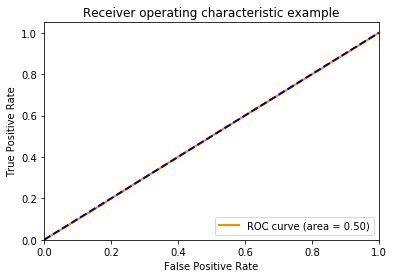

In [193]:
#Metrics
tes_first_neuron = [item[0] for item in df['real']] #get the first bit
print(len(tes_first_neuron))
print(len(df['score']))
predict_data = df

#predict_data['order'] = [fix_format(x) for x in predict_data['order']]

#function that calculate all metrics
metrics_DNN(predict_data['order'], tes_first_neuron,classes,predict_data['score'])

In [103]:
clean_pos

[0.004288200289011002]

In [90]:
a= df_score_pos.iloc[0].tolist()

In [91]:
a

[0.010439463891088963,
 0.0030943145975470543,
 0.0015069118235260248,
 3.238855060772039e-05]

In [86]:
df_score_pos.index[0]

0

In [68]:
print(len(df_all.pid))
print(len(pids_test))

347882
347882


In [69]:
df_all.head(100)

pid  score_pos1  score_neg1  score_pos2  score_neg2  \
0     GMHMC741-15    0.010439    0.743535    0.003094    0.999646   
1     GMMCF079-14    0.007744    0.759001         NaN         NaN   
2    BOWGF1045-10    0.008192    0.756142         NaN         NaN   
3     TANYT051-14    0.034122    0.675329    0.001084    0.999949   
4     GMGSS480-13    0.008081    0.756837    0.000111    0.999999   
5     GMMBB207-16    0.005472    0.776140         NaN         NaN   
6     JICCL861-16    0.005432    0.776490    0.271854    0.282684   
7     GMKME222-15    0.002860    0.805707         NaN         NaN   
8    WASPS1030-17    0.006535    0.767496         NaN         NaN   
9     ASANP217-09    0.001941    0.821863    0.000067    1.000000   
10    ANTPI558-15    0.006140    0.770556    0.001181    0.999941   
11   BOWGF1613-10    0.009149    0.750456    0.030323    0.975019   
12   GMBCC2113-15    0.009286    0.749683    0.000580    0.999984   
13   ASPNA2610-12    0.005708    0.774109         NaN         NaN   
14  GBMIN14497-13    0.008352    0.755155    0.000853    0.999968   
15    BGABA012-14    0.012098    0.735644         NaN         NaN   
16    GMIBE424-17    0.005454    0.776293         NaN         NaN   
17    GMAQV167-17    0.009297    0.749620    0.022090    0.986171   
18    GBMWB551-15    0.010946    0.741019    0.003577    0.999536   
19    GMMGB242-14    0.010228    0.744617    0.007438    0.998189   
20    CERAF428-09    0.014758    0.724736         NaN         NaN   
21    GMAMJ390-15    0.011095    0.740297    0.018408    0.990164   
22   GBAH10377-15    0.009116    0.750650    0.000005    1.000000   
23    GMIBA132-17    0.010108    0.745238         NaN         NaN   
24   GMATT3801-16    0.007052    0.763711         NaN         NaN   
25   AMTPD1960-15    0.013192    0.730936    0.000545    0.999986   
26    GMMBO316-16    0.011430    0.738705    0.123863    0.704417   
27    GLGS2210-17    0.003497    0.796861         NaN         NaN   
28    GMNZI492-14    0.009740    0.747186    0.004591    0.999262   
29   CNRVG2552-15    0.004816    0.782202         NaN         NaN   
..            ...         ...         ...         ...         ...   
70      TOA670-16    0.009390    0.749102    0.015261    0.993072   
71   CNWBG2033-13    0.001440    0.833588    0.000868    0.999967   
72    GMGGB678-17    0.005790    0.773416         NaN         NaN   
73    GMMCN615-15    0.005405    0.776725         NaN         NaN   
74    GMMDA382-15    0.042597    0.661272    0.339953    0.178382   
75    GMAAP570-16    0.009137    0.750523         NaN         NaN   
76   NGAAB1229-14    0.010453    0.743469         NaN         NaN   
77   JCCCC1771-16    0.005139    0.779136         NaN         NaN   
78   SMTPJ3316-14    0.011411    0.738794    0.025912    0.981367   
79   GMCCE1102-17    0.009374    0.749187    0.000425    0.999991   
80    GWOTK628-12    0.034203    0.675168    0.842680    0.002823   
81    GMMDC374-15    0.049126    0.652018         NaN         NaN   
82   BOTWA1157-11    0.014907    0.724178    0.000052    1.000000   
83    DEBUA340-17    0.009539    0.748280    0.000852    0.999968   
84    TTHYB193-09    0.010918    0.741158         NaN         NaN   
85    CHRSV419-10    0.012549    0.733663         NaN         NaN   
86    GMIBC633-17    0.009219    0.750058    0.000021    1.000000   
87     DARW715-15    0.005429    0.776518         NaN         NaN   
88    PNGFF027-10    0.010013    0.745738    0.007562    0.998132   
89    HDROS198-11    0.012835    0.732433    0.024439    0.983297   
90    SDRBB358-15    0.008625    0.753499         NaN         NaN   
91    PMNHE069-15    0.009706    0.747371         NaN         NaN   
92    GMCTE089-17    0.008775    0.752614    0.001067    0.999951   
93     BBWP248-09    0.003318    0.799213         NaN         NaN   
94     ASBR636-06    0.009727    0.747255    0.004526    0.999282   
95    GMNGQ087-16    0.002315    0.814660    0.010522    0.996541   
96   OPPAM16

In [45]:
%%time
import pandas as pd
#TEST
#GAMBIARRA FEIA

scores_pos = [] #Scores of each test data, for example scores[0] has the score of each NN for data[0]
scores_neg = []
score_ens = []
class_ens = []

#Initialize lists
for j in range(len(pids_test)):
    scores_pos.append([])
    scores_neg.append([])    
    
tf.reset_default_graph()    
model1 = build_DNN_Arch1(len(train_aa_x_1[0]), len(train_nu_x_1[0]),data_y_train_1)
model1.load(model_name1)
j =0
for pid in pids_test:
    if pid in pids_test_1:
        i = pids_test_1.index(pid)        
        _, scoreP, scoreN = predict(model1, test_aa_x_1[i], test_nu_x_1[i],classes)
        scores_pos[j].append(scoreP)
        scores_neg[j].append(scoreN)
        
    j += 1

tf.reset_default_graph()
model2 = build_DNN_Arch1(len(train_aa_x_2[0]), len(train_nu_x_2[0]),data_y_train_2)
model2.load(model_name2)    
j =0
for pid in pids_test:
    if pid in pids_test_2:
        #model2 = build_DNN_Arch1(len(train_aa_x_2[0]), len(train_nu_x_2[0]),data_y_train_2)
        #model2.load(model_name2,verbose=None)
        i = pids_test_2.index(pid)
        _, scoreP, scoreN = predict(model2, test_aa_x_2[i], test_nu_x_2[i],classes)
        scores_pos[j].append(scoreP)
        scores_neg[j].append(scoreN)
        
    j += 1

tf.reset_default_graph()
model3 = build_DNN_Arch1(len(train_aa_x_3[0]), len(train_nu_x_3[0]),data_y_train_3)
model3.load(model_name3)    
j =0
for pid in pids_test:
    if pid in pids_test_3:
        #model3 = build_DNN_Arch1(len(train_aa_x_3[0]), len(train_nu_x_3[0]),data_y_train_3)
        #model3.load(model_name3,verbose=None)
        i = pids_test_3.index(pid)        
        _, scoreP, scoreN = predict(model3, test_aa_x_3[i], test_nu_x_3[i],classes)
        scores_pos[j].append(scoreP)
        scores_neg[j].append(scoreN)
        
    j += 1
    
tf.reset_default_graph()
model4 = build_DNN_Arch1(len(train_aa_x_4[0]), len(train_nu_x_4[0]),data_y_train_4)
model4.load(model_name4)
j =0
for pid in pids_test:
    if pid in pids_test_4:
        #model4 = build_DNN_Arch1(len(train_aa_x_4[0]), len(train_nu_x_4[0]),data_y_train_4)
        #model4.load(model_name4,verbose=None)
        i = pids_test_4.index(pid)        
        _, scoreP, scoreN = predict(model4, test_aa_x_4[i], test_nu_x_4[i],classes)
        scores_pos[j].append(scoreP)
        scores_neg[j].append(scoreN)
        
    j += 1
    
for j in range(len(pids_test)):
    cls,scr = combination_1(scores_pos[j], scores_neg[j],classes)
    class_ens.append(cls)
    score_ens.append(scr)

INFO:tensorflow:Restoring parameters from /home/larissa/Desktop/sequence_classification/ensemble_classifiers/model/Lepidoptera_block_1_1.tflearn
INFO:tensorflow:Restoring parameters from /home/larissa/Desktop/sequence_classification/ensemble_classifiers/model/Lepidoptera_block_2_1.tflearn
INFO:tensorflow:Restoring parameters from /home/larissa/Desktop/sequence_classification/ensemble_classifiers/model/Lepidoptera_block_3_1.tflearn


KeyboardInterrupt: 

## Test

In [42]:
%%time
import pandas as pd
#TEST

scores_pos = [] #Scores of each test data, for example scores[0] has the score of each NN for data[0]
scores_neg = []
score_ens = []
class_ens = []
#cls_data = [] #Class of each test data, for example cls_data[0] has the class prediction of each NN for data[0]

model1 = build_DNN_Arch1(len(train_aa_x_1[0]), len(train_nu_x_1[0]),data_y_train_1)
model1.load(model_name1)
tf.reset_default_graph()
model2 = build_DNN_Arch1(len(train_aa_x_2[0]), len(train_nu_x_2[0]),data_y_train_2)
model2.load(model_name2)
tf.reset_default_graph()
model3 = build_DNN_Arch1(len(train_aa_x_3[0]), len(train_nu_x_3[0]),data_y_train_3)
model3.load(model_name3)
tf.reset_default_graph()
model4 = build_DNN_Arch1(len(train_aa_x_4[0]), len(train_nu_x_4[0]),data_y_train_4)
model4.load(model_name4)
print(model1)
print(model2)

j =0
cont = 0
for pid in pids_test:
    cont += 1
    scores_pos.append([])
    scores_neg.append([])
    print(float(cont)/len(pids_test))
    
    if pid in pids_test_1:
        #model1 = build_DNN_Arch1(len(train_aa_x_1[0]), len(train_nu_x_1[0]),data_y_train_1)
        #model1.load(model_name1,verbose=None)
        i = pids_test_1.index(pid)        
        _, scoreP, scoreN = predict(model1, test_aa_x_1[i], test_nu_x_1[i],classes)
        scores_pos[j].append(scoreP)
        scores_neg[j].append(scoreN)
        
    if pid in pids_test_2:
        #model2 = build_DNN_Arch1(len(train_aa_x_2[0]), len(train_nu_x_2[0]),data_y_train_2)
        #model2.load(model_name2,verbose=None)
        i = pids_test_2.index(pid)
        _, scoreP, scoreN = predict(model2, test_aa_x_2[i], test_nu_x_2[i],classes)
        scores_pos[j].append(scoreP)
        scores_neg[j].append(scoreN)
        
    if pid in pids_test_3:
        #model3 = build_DNN_Arch1(len(train_aa_x_3[0]), len(train_nu_x_3[0]),data_y_train_3)
        #model3.load(model_name3,verbose=None)
        i = pids_test_3.index(pid)        
        _, scoreP, scoreN = predict(model3, test_aa_x_3[i], test_nu_x_3[i],classes)
        scores_pos[j].append(scoreP)
        scores_neg[j].append(scoreN)
        
    if pid in pids_test_4:
        #model4 = build_DNN_Arch1(len(train_aa_x_4[0]), len(train_nu_x_4[0]),data_y_train_4)
        #model4.load(model_name4,verbose=None)
        i = pids_test_4.index(pid)        
        _, scoreP, scoreN = predict(model4, test_aa_x_4[i], test_nu_x_4[i],classes)
        scores_pos[j].append(scoreP)
        scores_neg[j].append(scoreN)
        
    cls,scr = combination_1(scores_pos[j], scores_neg[j],classes)
    class_ens.append(cls)
    score_ens.append(scr)
        
    j += 1

    


INFO:tensorflow:Restoring parameters from /home/larissa/Desktop/sequence_classification/ensemble_classifiers/model/Lepidoptera_block_1_1.tflearn
INFO:tensorflow:Restoring parameters from /home/larissa/Desktop/sequence_classification/ensemble_classifiers/model/Lepidoptera_block_2_1.tflearn
INFO:tensorflow:Restoring parameters from /home/larissa/Desktop/sequence_classification/ensemble_classifiers/model/Lepidoptera_block_3_1.tflearn
INFO:tensorflow:Restoring parameters from /home/larissa/Desktop/sequence_classification/ensemble_classifiers/model/Lepidoptera_block_4_1.tflearn


AttributeError: 'DNN' object has no attribute 'get_all_variables'